## Team ES2 Unsupervised Predict Student Solution

### *EDSA Movie Recommendation 2022*

 © Explore Data Science Academy

We {TEAM ES2}, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the EDSA honour code.

Non-compliance with the honour code constitutes a material breach of contract

<center><img src="https://raw.githubusercontent.com/jalajthanaki/Movie_recommendation_engine/master/img/3_1.gif" 
align="middle" alt="Figure 3_1" data-canonical-src="" style="width:40%;height:40%"></center>

### Meet the members

- Elizabeth Ajabor
- Maureen Mbugua
- Wasiu Ogunkoya
- Mohamed Abubakar
- Emmanuel Adetunji
- Oluwasola Osatuyi

### Table of Contents
---
1. [Introduction](#intro)
 * Background
 * Problem Statement
---
2. [Load Dependencies](#imports)
 * Connecting to Comet
 * Libraries
 * Data
 * Data Definitions
---
3. [Exploratory Data Analysis](#EDA)
 * Data Summary
 * Missing Values
 * Ratings
 * Preparing data for better visualization
 * MoveLens rating distribution
 * Genres
---
4. [Simple Recommendation Model](#pre-modelling)
 * IMDB's weighted rating formula
 * Calculating weighted ratings and making top 250 chart
 * Rating distribution: Jurassic Park
---
5. [Modelling](#modelling)
 * Content-based Filtering
 * Collaborative Filtering
 * Hybrid Recommendation Systems 
 ---
6. [Performance Evaluation](#evaluation)
 * Root Mean Squared Error (RMSE)
 * Cross Validation
---
7. [Model Analysis](#analysis)
 * Hyperparameter Tuning
 * Results
---
8. [Conclusion](#conclusion)
---
9. [Submission](#submission)
---
10. [References](#reference)
--- 

![popcorn.gif?w=371](https://watchaholichome.files.wordpress.com/2018/11/popcorn.gif?w=371)

#### "You don't have to be great to start but you have to start to be great..."

<a id="intro"></a>
## 1. Introduction  

### Background

In today's technologically driven world, recommender systems are critical to ensuring that users can make informed decisions about the content they interact with on a daily basis.

When shopping online, recommender systems assist users in selecting similar items. Netflix or Amazon would recommend various movies and titles that might be of interest to individual users. These systems could be used in education to recommend learning materials that could improve educational outcomes. These algorithms improve service and increase customer satisfaction. They accomplish this by addressing the long-tail problem depicted below.

<img src="https://github.com/Lizette95/unsupervised-predict-streamlit-template/blob/master/resources/imgs/long_tail.png?raw=true" width="500" align="center">
    
Customers do not have the time to look through every available product, and businesses cannot simply discontinue selling less popular items. A recommender system solves the long-tail problem by recommending less popular content that the customer is likely to find valuable.

Currently available recommendation systems - content-based and collaborative filtering - make recommendations using various information sources.

#### Content-based filtering

This method makes product feature recommendations based on user preferences. It can recommend new items, but it is limited by the need for more user preference data to improve recommendation quality.

#### Collaborative filtering

User-to-user recommendations are simulated by collaborative filtering. In other words, if you and your friend have similar tastes, you are more likely to make recommendations that the other will like. This method identifies and predicts similar users' preferences as a linear, weighted combination of other users' preferences. The limitation is the need for a large dataset with active users who have previously rated a product in order to make accurate predictions. Because of this limitation, collaborative systems frequently suffer from the "cold start" problem, making predictions for new users difficult. This is usually overcome by initiating a user profile using content-based filtering.

#### Hybrid systems

A combination of these two recommendations systems is called a hybrid system. They mix the features of the item itself and the preferences of other users.

### Problem Statement
Create a recommendation algorithm based on content or collaborative filtering that can accurately predict how a user will rate a movie they haven't yet seen based on their previous preferences.

<a id="imports"></a>
## 2. Load Dependencies

### Connecting to comet

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment


In [2]:


# Create an experiment with your api key
experiment = Experiment(
    api_key="AxjWun6MBU55rZhxlaFzKCrDQ",
    project_name="unsupervised-predict-team-es2",
    workspace="mowmanabdul",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/mowmanabdul/unsupervised-predict-team-es2/32bc968ab0b448b7b64708a40ac66852



### Libriaries

In [1]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re

# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
%matplotlib inline
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from surprise import SVD, NormalPredictor, BaselineOnly, NMF, SlopeOne, CoClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity


import warnings; warnings.simplefilter('ignore')

In [3]:
movies = pd.read_csv('movies.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
links = pd.read_csv('links.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')

In [5]:
print(movies.shape)
print(imdb_data.shape)
print(tags.shape)
print(train.shape)
print(test.shape)


(62423, 3)
(27278, 6)
(1093360, 4)
(10000038, 4)
(5000019, 2)


- The Full Dataset: Consists of 10,000,038 ratings and 1093360 tag applications applied to 62423 movies by 500,000 users. 
- The Small Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

Our Simple Recommender will be built using movies from the Full Dataset, whereas all personalized recommender systems will use the small dataset (due to the computing power we possess being very limited). 

In [6]:
# Display the first 5 entries in each dataframe 
display(movies.head())
display(imdb_data.head())
display(tags.head())
display(train.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


### Data Definitions

**Numeric**
* **budget:** - (continuous) dollar cost of production of the movie.
* **rating:** - (discrete) users rating of a movie from. **TARGET**
* **relevance:** - (continuous) measure (0-1) of the relevance of a genome tag to the movie, where 1 impies 100% relevance.
* **runtime:** - (continuos) movie duration in minutes.
* **timestamp:** - (continuous) the time at which a user rated the movie.


**Categorical**
* **director:** - (nominal) the person who controls the making of a film and supervises the actors and technical crew.
* **genres:** - (nominal) the style or category of the movie. A movie may belong to multiple (up to nineteen) genres, or may be absent a genre listing.
* **imdbId:** - (nominal) unique indentifying key for each IMBD entry. Can also be used in conjunction with the TMDB API.
* **movieId:** - (nominal) a unique identifier for each movie. There are 48,213 unique movies.
* **plot_keywords:** - (nominal) key words used to identify characteristics of a movie's storyline.
* **tag:** - (nominal) genome label
* **tagId:** - (nominal) unique genome identifier.
* **tmdbId:** - (nominal) unique identifier that works in conjunction with the TMDB API.
* **title:** - (nominal) the unique title identifying the movie. Included is a year of release enclosed in parenthesis at the end of the title.
* **title_cast:** - (nominal) the actors of the main characters in the movie. This does not include extras.
* **userId:** - (nominal) a unique identifier for each user. There are 162,541 unique users.

*The Movie Genome concept is borrowed from the Human Genome Project, a scientific project to identify and map all human genes. Similarly, a Movie Genome identifies and indexes multiple “genes” (elements and aspects) of a movie.*

<a id="EDA"></a>
## 3. Exploratory Data Analysis

### Data Summary

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [10]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [11]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [12]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [13]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


### Missing Values

In [15]:
print("Train: ")
print(str(train.isnull().sum()))
print("============")
print("Test: ")
print(str(test.isnull().sum()))
print("============")
print("Movies: ")
print(str(movies.isnull().sum()))
print("============")
print("Links: ")
print(str(links.isnull().sum()))
print("============")
print("IMDB: ")
print(str(imdb_data.isnull().sum()))
print("============")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("============")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Test: 
userId     0
movieId    0
dtype: int64
Movies: 
movieId    0
title      0
genres     0
dtype: int64
Links: 
movieId      0
imdbId       0
tmdbId     107
dtype: int64
IMDB: 
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
Genome scores: 
movieId      0
tagId        0
relevance    0
dtype: int64
Genome tags: 
tagId    0
tag      0
dtype: int64


In [15]:
# Drop missing rows
# tags_df.dropna(axis=0,inplace=True)
links.dropna(axis=0,inplace=True)

### Ratings

In [16]:
def user_ratings_count(df, n):
    """
    Counts the number of user ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        n (int): number of users to show
    Returns
    -------
        barplot (NoneType): barplot of top n users by number of observations
    Example
    -------
        >>> df = pd.DataFrame({'userId':[1,2,3,1,2,4,5,4]})
        >>> user_ratings_count(df, 3)
            NoneType (barplot)
    """
    plt.figure(figsize=(8,6))
    data = df['userId'].value_counts().head(n)
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='brg', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=11, ha='center', va='bottom')
    plt.title(f'Top {n} Users by Number of Ratings', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Number of Ratings')
    print("Combined number of ratings:\t",df['userId'].value_counts().head(n).sum(),
         "\nTotal number of movies:\t\t", df['movieId'].nunique())
    plt.show()

Combined number of ratings:	 34398 
Total number of movies:		 48213


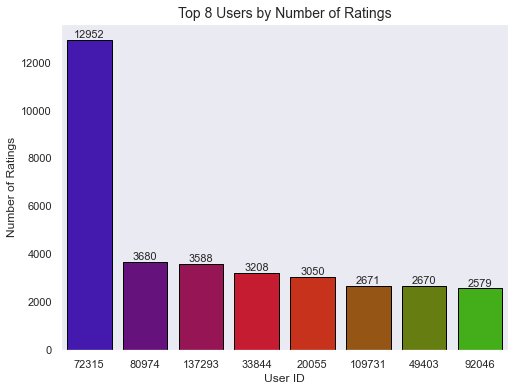

In [17]:
user_ratings_count(train,8)

Fig 1. User 72315 has rated an extreme number of movies relative to other users. For EDA purposes, this user is removed to make interpretation easier.

In [18]:
# Exclude user 72315 for EDA
eda_df = train[train['userId']!=72315]

Combined number of ratings:	 23734 
Total number of movies:		 45844


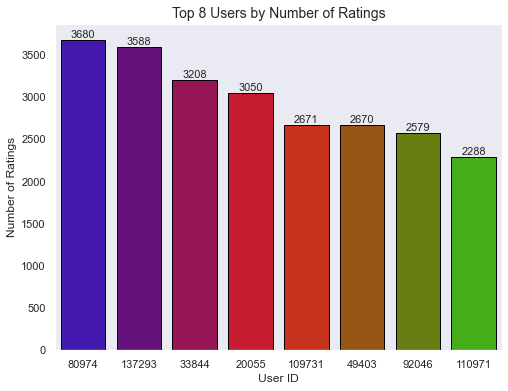

In [19]:
user_ratings_count(eda_df,8)

In [20]:
# How many ratings have we lost?
34398-23734

10664

In [21]:
# How many movies were only rated by our outlier?
48213-45844

2369

Our outlier user clearly rated a large number of films. The decrease in unique ratings suggests that he may have been the only person watching those movies. As a result, the recommender will use him as a baseline for those movies.

### Data Summary

In [20]:

# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


Lowest rating: 0.5
Highest rating: 5.0


### Preparing the data for better visualization

To begin, we select the movie features that we want to investigate and create a new dataframe with these features.

In [21]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


Action strategy:

- Transform data types into strings
- Remove the pipes that separate the words.
- Keep the number of keywords and cast members per film to a minimum.
- Remove spaces between actors' and directors' surnames and names. This is done to avoid name confusion or misinterpretation later on.

In [22]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


### MoveLens rating distribution

We can now begin to delve deeper into the movielens dataset. Let's see what we can find out.

Just because a film has been seen by a large number of people does not necessarily imply that the audience enjoyed it. More explicit data is useful for understanding how a viewer actually felt about a film. Now we'll find the average rating of each movie in the dataset, followed by the movie with the highest average rating.

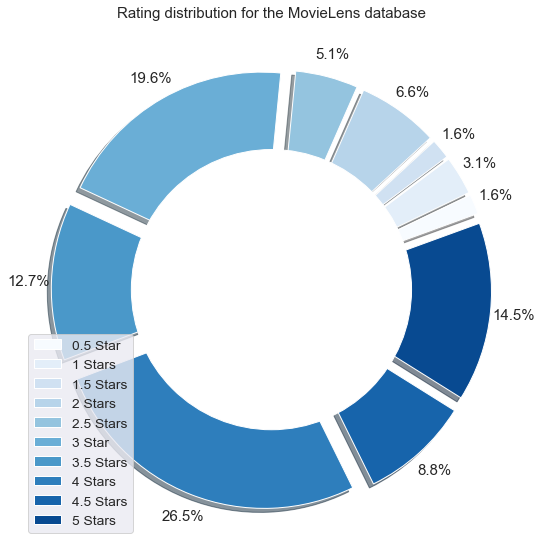

In [23]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings['title']=ratings['title'].str.replace('\d+', '')
ratings['title']=ratings['title'].str.replace('(','').str.replace(')','')
ratings['title']=ratings['title'].str.strip() 
ratings.drop('timestamp', axis=1, inplace=True)


# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Blues')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

Observations:

- 4 Star ratings account for the majority of ratings in the MovieLens dataset, accounting for 26.5 percent of total ratings.
- 5 star ratings account for 14.5 percent of total ratings (3rd largest portion)
- 0.5 star ratings account for the smallest proportion of ratings, accounting for only 1.6 percent.
- 12.9 percent of ratings are between 2 and 0.5 stars.

Q: How do users tend to rate movies?

In [24]:
def ratings_distplot(df, column='rating'):
    """
    Plots the distribution of ratings in the dataset.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        column (str): column to plot
    Returns
    -------
        distplot (NoneType): distplot of rating frequencies
    """
    plt.figure(figsize=(8,6))
    ax = sns.distplot(df[f'{column}'],bins=10, kde=False, hist_kws=dict(alpha=0.6),color="blue")
    mean = df[f'{column}'].mean()
    median = df[f'{column}'].median()
    plt.axvline(x=mean, label = f'mean {round(mean,2)}' , color='#4D17A0', lw=3, ls = '--')
    plt.axvline(x=median, label = f'median {median}' , color='#4DA017', lw=3, ls = '--')
    plt.xlim((0.5,5))
    plt.ylim((0,2500000))
    plt.title(f'Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

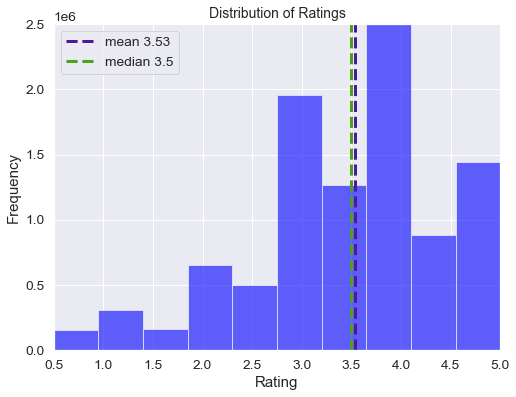

In [25]:
ratings_distplot(eda_df)

It's worth noting that the ratings are skewed to the left. It was expected that the distribution would be normal, with a mean rating of 3. Instead, we find that users tend to rate movies favorably and avoid giving negative ratings. This skew could be explained by users' proclivity to rate movies they enjoy. In other words, if a user dislikes a film, it is unlikely that they will watch it all the way through, let alone rate it.

Q: Is there a correlation between the number of movies rated by a user and the rating they give?

In [26]:
def mean_ratings_scatter(df, color='#4DA017', column='userId'):
    """
    Make scatterplots of mean ratings.
    Parameters
    ----------
        df (DataFrame): input DataFrame
        color (str): plot colour
        column (str): column to plot
    Returns
    -------
        scatterplot (NoneType): scatterplot of mean number of ratings
    """
    plt.figure(figsize=(6,4))
    mean_ratings = df.groupby(f'{column}')['rating'].mean()
    user_counts = df.groupby(f'{column}')['movieId'].count().values
    sns.scatterplot(x=mean_ratings, y = user_counts, color=color)
    plt.title(f'Mean Ratings by Number of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Number of Ratings')
    plt.show()

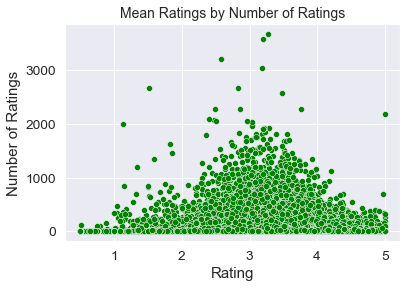

In [27]:
# Mean user ratings by number of ratings
mean_ratings_scatter(eda_df,'green')

There does not appear to be a relationship, as there is no correlation between the number of ratings and how a user rates a movie.

Q: Is there a correlation between the number of ratings a movie has and its rating?

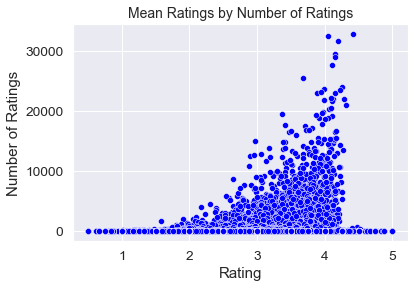

In [28]:
# Mean movie ratings by number of ratings
mean_ratings_scatter(eda_df, column='movieId', color='blue')

This time, we do see a relationship: the higher a movie's rating, the higher it is likely to be rated. This confirms our intuitive understanding that the higher the rating of a film, the more likely it is that viewers will recommend it to one another. In other words, most people try to avoid making poor recommendations.

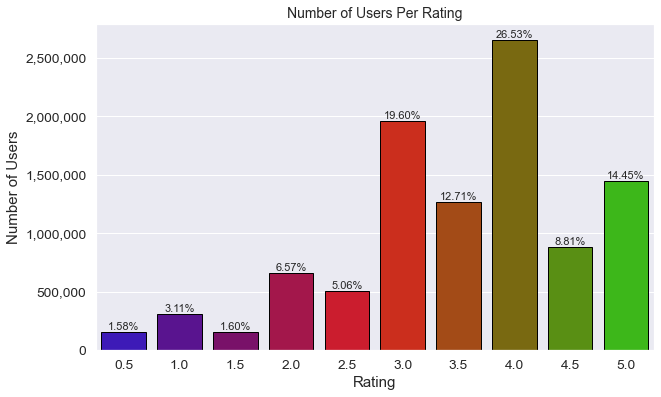

In [29]:
movieRatingDistGroup = train['rating'].value_counts().sort_index().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=movieRatingDistGroup, x='index', y='rating', palette="brg", edgecolor="black", ax=ax)
ax.set_xlabel("Rating")
ax.set_ylabel('Number of Users')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
total = float(movieRatingDistGroup['rating'].sum())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+350, '{0:.2%}'.format(height/total), fontsize=11, ha="center", va='bottom')
plt.title('Number of Users Per Rating', fontsize=14)
plt.show()

### Genres

In [30]:
# function that hasn't found a use yet - it was usefull in the app!!
def feat_extractor(df, col):
    """
    Returns a list of all unique features in a DataFrame columns separated by "|"
    """
    df.fillna("", inplace=True)
    feat_set = set()
    for i in range(len(df[f'{col}'])):
        for feat in df[f'{col}'].iloc[i].split('|'):
            feat_set.add(feat)
    return sorted([feat for feat in feat_set if feat != ""])

In [31]:
genres = feat_extractor(movies, 'genres')

Q: Which genres are the most commonly observed?

In [32]:
def feature_frequency(df, column):
    """
    Function to count the number of occurences of metadata such as genre
    Parameters
    ----------
        df (DataFrame): input DataFrame containing movie metadata
        column (str): target column to extract features from
    Returns
    -------
        
    """
    # Creat a dict to store values
    df = df.dropna(axis=0)
    genre_dict = {f'{column}': list(),
                 'count': list(),}
    # Retrieve a list of all possible genres
    print('retrieving features...')
    for movie in range(len(df)):
        gens = df[f'{column}'].iloc[movie].split('|')
        for gen in gens:
            if gen not in genre_dict[f'{column}']:
                genre_dict[f'{column}'].append(gen)
    # count the number of occurences of each genre
    print('counting...')
    for genre in genre_dict[f'{column}']:
        count = 0
        for movie in range(len(df)):
            gens = df[f'{column}'].iloc[movie].split('|')
            if genre in gens:
                count += 1
        genre_dict['count'].append(count)
        
        # Calculate metrics
    data = pd.DataFrame(genre_dict)
    print('done!')
    return data
genres = feature_frequency(movies, 'genres')

retrieving features...
counting...
done!


In [33]:
def feature_count(df, column):
    plt.figure(figsize=(10,6))
    ax = sns.barplot(y = df[f'{column}'], x = df['count'], palette='brg', orient='h')
    plt.title(f'Number of Movies Per {column}', fontsize=14)
    plt.ylabel(f'{column}')
    plt.xlabel('Count')
    plt.show()

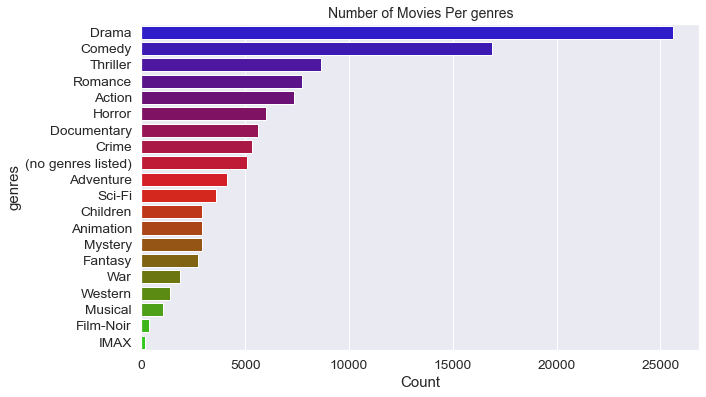

In [34]:
feature_count(genres.sort_values(by = 'count', ascending=False), 'genres')

The most frequently occurring genre in the database is drama. Approximately 5000 films lack genres. We can use the IMDB and TMDB IDs in conjunction with the APIs to fill in the blanks. Furthermore, IMAX is a proprietary system for mass viewings rather than a genre.

<a id="pre-modelling"></a>
## 4. Simple Recommendation Model

Procedure is as follow:

- First sort movies based on ratings and popularity
- Display the top movies of list.

The model simply makes generalized recommendations to all users based on the popularity of the movie. The logic behind the model is that the average audience will probably choose or like movies that are critically acclaimed and popular. This model does not provide user-specific recommendations.

### IMDB's *weighted rating* formula 

Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

Now, determine an cutoff value for *m*, the minimum votes required to be listed in the chart. 

in this model used cutoff is **95th percentile** that means for a movie to feature in the top N must have more votes than at least 95% of the movies in the list.

In [35]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

In [ ]:
ratings_mean_count.head()

,rating,rating_counts,popularity
title,,,
,3.352286,17913,60049.5
"""BLOW THE NIGHT!"" Let's Spend the Night Together",3.000000,1,3.0
"""Great Performances"" Cats",2.753731,67,184.5
# Cheerleader Camp,1.900000,5,9.5
#Female Pleasure,4.000000,1,4.0


In [36]:
# Calculation of C 
rating_counts = ratings_mean_count[ratings_mean_count['rating_counts'].notnull()]['rating_counts'].astype('int')
rating_averages = ratings_mean_count[ratings_mean_count['rating'].notnull()]['rating'].astype('int')
C = rating_averages.mean()
C

2.703723427861359

In [37]:
## Calculation of m
m = rating_counts.quantile(0.95)
m

882.0

In [38]:
col_list = [ 'rating','rating_counts', 'popularity']
qualified = ratings_mean_count[(ratings_mean_count['rating_counts'] >= m) 
                 & (ratings_mean_count['rating_counts'].notnull()) 
                 & (ratings_mean_count['rating'].notnull())][col_list]

# converting vote_count and vote_average colums to integer
qualified['rating_counts'] = qualified['rating_counts'].astype('int')
qualified['rating'] = qualified['rating'].astype('int')
qualified.shape

(2256, 3)

Findings as follow:
1. for consideration in the chart, a movie has to have at least **882 votes**. 
2. the average rating for a movie is **2.701** on a scale of 5. 
3. **2256** Movies qualify to be on the chart.

### Calculating weighted ratings and making top 250 chart

In [39]:
def weighted_rating(x):
    v = x['rating_counts']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [40]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [41]:
qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)

### Top 10 Movies

In [42]:
qualified.head(10)

,rating,rating_counts,popularity,weighted_rating
title,,,,
"Shawshank Redemption, The",4,32831,145035.0,3.966087
Forrest Gump,4,32383,131061.0,3.965630
Pulp Fiction,4,31697,132972.0,3.964906
"Silence of the Lambs, The",4,29444,122021.0,3.962299
"Matrix, The",4,29014,120531.5,3.961757
Star Wars: Episode IV - A New Hope,4,27560,113321.5,3.959802
Schindler's List,4,24004,101960.0,3.954058
Fight Club,4,23536,99508.0,3.953177
Star Wars: Episode V - The Empire Strikes Back,4,22956,95181.0,3.952038


**And the most popular movie is... The Shawshank redemption!!**

![13-Best-Shawshank.jpg](https://traditiononline.org/wp-content/uploads/2019/11/13-Best-Shawshank.jpg)

Observations:

- We see some really good movies in the top 10, such as The Martrix, Star Wars, and The Lord of the Rings.
- The preceding list demonstrates that good movies typically receive both more and higher ratings.
- It's worth noting that all of the films in the top ten are older, with none being released after 1999.
- This could simply be because these films have been around for a longer period of time and thus have received higher ratings as a result.

### Movie genres


#### Trends in genre popularity
The following figure shows the number of ratings movies from each genre have received over the last 50 years.

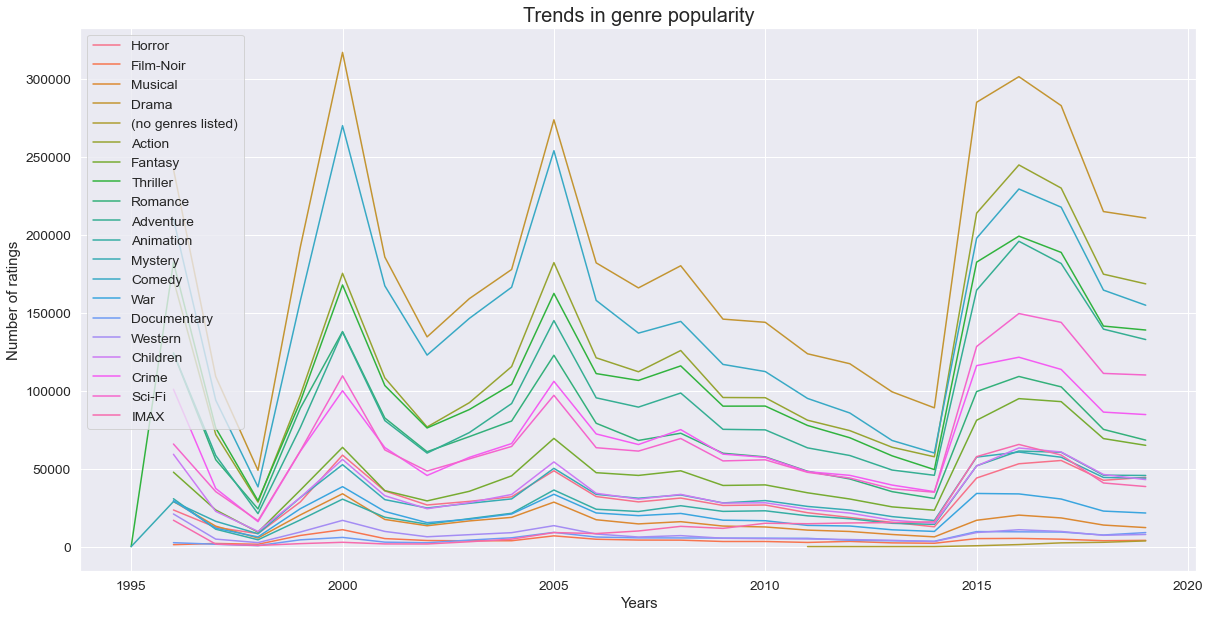

In [44]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    Input: input_df
           datatype: DataFrame
           
    Output: None
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    
    return

most_watched(train)

Observations: 

- The majority of genres exhibit a similar trend, with a significant uptick in 2015. This could be due to an increase in users or an increase in the quantity of films released.
- We also notice that the number of films graded in each genre sharply increased in 1996 before dramatically declining over the next two years.
- It's also important to note that during the past five years, the number of movie ratings has decreased overall.

In [45]:
df["year_made"] = df["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)+$", x)) 
                                                  if re.findall(r"\((\d+)\)+$", x) else 0)

df.head()

,movieId,title_cast,director,plot_keywords,genres,title,year_made
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995),1995
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995),1995
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995),1995
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995),1995
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995),1995


In [46]:
# Splitting each genre to each movies
genre = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genre.name = 'genre'
df_mov_gen = df.drop('genres', axis=1).join(genre)
df_mov_gen['title']=df_mov_gen['title'].str.replace('\d+', '')
df_mov_gen['title']=df_mov_gen['title'].str.replace('(','').str.replace(')','')
df_mov_gen['title']=df_mov_gen['title'].str.strip() 
df_mov_gen.head()


,movieId,title_cast,director,plot_keywords,title,year_made,genre
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,Toy Story,1995,adventure animation children comedy fantasy
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,Jumanji,1995,adventure children fantasy
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,Grumpier Old Men,1995,comedy romance
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,Waiting to Exhale,1995,comedy drama romance
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,Father of the Bride Part II,1995,comedy


In [47]:
# Converting 'year_made' into numeric datatype
df_mov_gen["year_made"] = df_mov_gen["year_made"].astype('int64')

### Plot keywords
Lets have a look at the most frequently occuring plot keywords in the movielens dataset

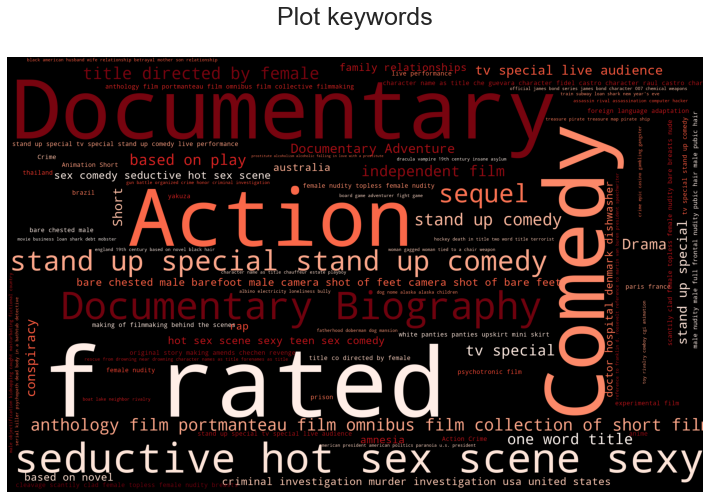

In [48]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()


Observations: 

- The collection has more instances of words that stand out.
- One of the things that jumps out is "F-rated," which refers to a feminist rating system that highlights movies with female writers, directors, or stars.
- Some terms that are associated with comedy include "Comedy," "stand-up special," and "stand-up comedy."
- Popular keyword phrases include conspiracy, biography, and documentaries.
- The wordcloud is filled with words like "Seductive," "hot," "sexy," "sex scene," etc. This is due to the fact that most movies, regardless of their genre, seem to have some sex appeal.

### Directors

The aesthetic and dramatic elements of a movie are in the direction of the director, who also visualizes the script and directs the performers and technical staff to realize that vision. Cast member selection, production design, and all other artistic components of filmmaking are crucially influenced by the director.

Let's examine the directors more closely who regularly feature in our dataset. They must be succeeding in some way.


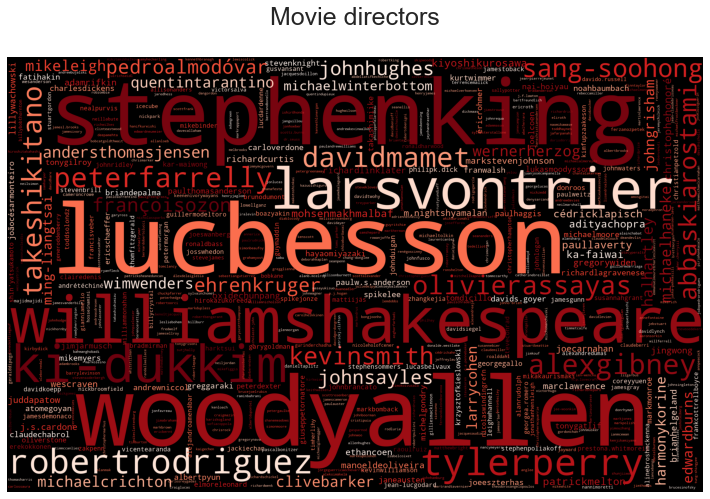

In [49]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()


Observations: 

- Right away, certain well-known actors in the film industry spring out at us, proving that our intuition was correct.
- Shakespeare and Stephen King? Well.. The likelihood that these movies were based on their work is higher.
- Woody Allen is an American filmmaker, writer, actor, and comedian whose work includes several Academy Award-winning films and a career spanning more than six decades.
- Tyler Perry is the director of numerous excellent movies, including Acrimony and the Madea movies. He now runs his own film production company, Tyler Perry Studios.
- Luc French filmmaker, writer, and producer Paul Maurice Besson is also a producer. The Big Blue, La Femme Nikita, and Subway were all movies he either directed or produced. Besson is linked to the cinéma du look movement in movies.

### Actors

We all have actors who, in our opinion, can do no wrong and whom we simply adore watching. The cast of a movie will undoubtedly have an impact on how much you like or how highly you grade it.

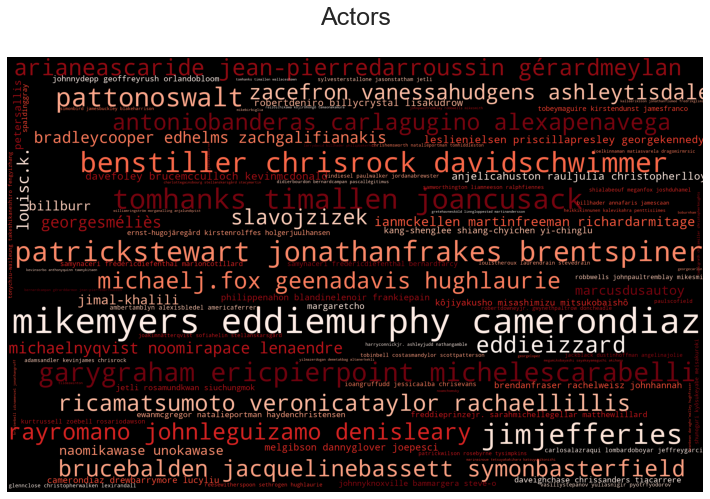

In [50]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()

Observations: 

- American actor and director Tom Hanks. Hanks is one of the most well-known and recognizable film actors in the world and is considered as an American cultural icon. He is known for both his humorous and tragic parts.

- Ben Stiller: Over the course of his career, he has written, starred in, directed, or produced more than 50 movies, including There's Something About Mary, The Cable Guy, The Secret Life of Walter Mitty, and Zoolander.

- Chris Rock and Eddie Murphy, two popular comedians who have transitioned to acting, have both appeared in a number of movies throughout the course of their careers.


<a id="modelling"></a>
## 5. Model Analysis

Recommender systems use two types of information to operate:

1. Data on characteristics, information on items (keywords, categories, etc.) and users is provided here (preferences, profiles, etc.).

2. User-item exchanges,this data includes things like ratings, the quantity of transactions, likes, etc.



This allows us to differentiate between three algorithms that are applied in recommender systems:

1. Content-based systems that make use of trait data.

2. User-item interactions-based collaborative filtering systems.

3. Hybrid systems, which mix both forms of information in order to prevent the issues that arise from using only one.



![movie-recommendation-system-aa204f0700eb](https://miro.medium.com/max/1400/1*nQvD0rDEWzhhx-Eiurhung.png)

### Content based filtering 

Recommenders of content base their recommendations on item features. Several instances of this are:

- A content-based system proposes things to you based on past preferences.
- Items are recommended based on the user's past purchases, ratings, and likes.
- Combine: Descriptions of items and user profiles
- Calculate the similarity score.
- On the basis of the similarity score, suggest the items.

The movie's content (genre, keywords, cast, directors) will be used in this recommender system to determine whether it is similar to other films. Then, recommended films are those that are most likely to be comparable. Therefore, let's build a model that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. For that we have to consider metadata (or content), hence, it also known as **Content Based Filtering.**

Two Content Based Recommendation is implemented based on different contents:
1. Description Based (content: Keywords and Taglines)
2. Meta Data Based (content : Movie Cast, Crew,  and Genre)

** Note **: A small movie data set is used due to limiting computing power. 




In [51]:
tags = pd.read_csv('tags.csv')
sample_tag = tags.iloc[0:1000, :].copy()

In [52]:
sample_tag = sample_tag.drop(['userId','timestamp'], axis=1)

In [53]:
sample_tag.head(2)

,movieId,tag
0,260,classic
1,260,sci-fi


In [54]:
df_movies = df_mov_gen.iloc[0:10000, :].copy()
df_movies.shape

(10000, 7)

In [55]:
df_movies = pd.merge(df_movies, sample_tag, on='movieId')

In [56]:
df_movies

,movieId,title_cast,director,plot_keywords,title,year_made,genre,tag
0,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,Grumpier Old Men,1995,comedy romance,funny
1,17,"[jamesfleet, tomwilkinson, harrietwalter]",janeausten,england 19th century based on novel black hair,Sense and Sensibility,1995,drama romance,chick flick
2,150,"[tomhanks, billpaxton, kevinbacon]",jimlovell,1970s survival astronaut space mission,Apollo,1995,adventure drama imax,space program
3,178,"[thomasgibson, ruthmarshall, cameronbancroft]",denysarcand,lesbian dominatrix gay sex,Love & Human Remains,1993,comedy drama,Bisexual
4,178,"[thomasgibson, ruthmarshall, cameronbancroft]",denysarcand,lesbian dominatrix gay sex,Love & Human Remains,1993,comedy drama,Canadian
...,...,...,...,...,...,...,...,...
407,30803,"[seung-yunlee, heejae, hyuk-hokwon]",ki-dukkim,abusive husband motorcycle golf drifter,-Iron Bin-jip,2004,drama romance,quiet
408,30803,"[seung-yunlee, heejae, hyuk-hokwon]",ki-dukkim,abusive husband motorcycle golf drifter,-Iron Bin-jip,2004,drama romance,quirky
409,30803,"[seung-yunlee, heejae, hyuk-hokwon]",ki-dukkim,abusive husband motorcycle golf drifter,-Iron Bin-jip,2004,drama romance,silent
410,30803,"[seung-yunlee, heejae, hyuk-hokwon]",ki-dukkim,abusive husband motorcycle golf drifter,-Iron Bin-jip,2004,drama romance,very little dialogue


**10000** movies avaiable in our small movies metadata dataset 

### 1. Description Based Recommendation

In [57]:
df_movies['description'] = df_movies['plot_keywords'] + df_movies['tag']
df_movies['description'] = df_movies['description'].fillna('')

#### Compute TF-IDF matrix 

In [58]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_movies['description'])
tfidf_matrix.shape

(412, 1527)

#### Cosine Similarity

The Cosine Similarity is used to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since the TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, sklearn's **linear_kernel** is used instead of cosine_similarities as it's much faster.


The measure of cosine similarity compares two vectors in an inner product space. If two vectors are roughly pointing in the same direction, it can be determined by computing the cosine of the angle between them. It is frequently employed in text analysis to gauge document similarity.

The mathematical equation of Cosine similarity between two non-zero vectors is:

![](https://global-uploads.webflow.com/5ef788f07804fb7d78a4127a/60dee7e4dec6611dc63cb158_dNiiYIrknDdfDwnqRpJ4n23givOOrrkWvlsBED9hE7qahtn_itdM1ziLQm0YYmqlV2j5q1Kur_icFc_K1jyYKIAcz_PBZ32OjpaFVQGAf41K3O0PhVRnnROFNnb_04jQ36VcX8pF.png)

#### How does it work?
The value of cosine similarity is restricted to the range between 0 and 1.

The cosine of the angle between the two non-zero vectors A and B is measured by the similarity metric.

Let's say there was a 90-degree angle between the two vectors. The cosine similarity will then have a value of 0, indicating that the two vectors are perpendicular or orthogonal to one another.

The angle between the two vectors, A and B, decreases as the cosine similarity measurement approaches 1. This is more clearly shown in the pictures below.

![](https://miro.medium.com/max/1400/1*IhpY-6LYV75983THCpWo-w.png)

In [59]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [60]:
cosine_sim[0]

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 50 most similar movies based on the cosine similarity score.

In [61]:
df_movies['title']=df_movies['title'].str.replace('\d+', '')
df_movies['title']=df_movies['title'].str.replace('(','').str.replace(')','')
df_movies['title']=df_movies['title'].str.strip() 

In [62]:
df_movies = df_movies.reset_index()
titles = df_movies['title']
indices = pd.Series(df_movies.index, index=df_movies['title'])

In [63]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let us now try and get the top 10 recommendations for a few movies.

In [64]:
get_recommendations('Grumpier Old Men').head(10)

244           Grumpy Old Men
1      Sense and Sensibility
2                     Apollo
3       Love & Human Remains
4       Love & Human Remains
5       Love & Human Remains
6       Love & Human Remains
7       Love & Human Remains
8       Love & Human Remains
9       Love & Human Remains
Name: title, dtype: object

In [65]:
get_recommendations('Toy Story').head(10)

53             Forrest Gump
0          Grumpier Old Men
1     Sense and Sensibility
2                    Apollo
3      Love & Human Remains
4      Love & Human Remains
5      Love & Human Remains
6      Love & Human Remains
7      Love & Human Remains
8      Love & Human Remains
Name: title, dtype: object

We see that for **Toy Story**, our system is able to identify it as a toy story film and subsequently recommend other toy story films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew and director, which determine the rating and the popularity of a movie. Someone who liked **Toy Story** probably likes it more because of Chipmunk Adventure and would hate **Toy Story 2** and every other substandard movie in the Toy Story Franchise.

Therefore, we are going to use much more suggestive metadata than **plot_keywords** and **genre**. In the next subsection, Let's build a more sophisticated recommender that takes **director** and **cast** into consideration.

The approach to developing the recommendation will be extremely hacky. The plan is to create a metadata dump for each movie that includes **genres, director, main actors, and keywords.** Then, just like in the Description Recommender, we use a **Count Vectorizer** to create our count matrix. The remaining steps are the same as before: we compute the cosine similarities and return the movies that are most similar.


Keywords occur in a frequency range of 1 to 610. We have no use for keywords that appear only once. As a result, these can be safely removed. Finally, we will convert each word to its stem so that words like *Dogs* and *Dog* are considered synonymous.

In [66]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [67]:
df_mov_gen['title']=df_mov_gen['title'].str.replace('\d+', '')
df_mov_gen['title']=df_mov_gen['title'].str.replace('(','').str.replace(')','')
df_mov_gen['title']=df_mov_gen['title'].str.strip() 

In [68]:
df_mov_gen = df_mov_gen.iloc[0:10000, :]

In [69]:
df_mov_gen['soup'] = df_mov_gen['plot_keywords']  + df_mov_gen['director'] + df_mov_gen['genre']
df_mov_gen['soup'] =df_mov_gen['soup'].fillna('')

In [70]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(df_mov_gen['soup'])

In [71]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [72]:
df_mov_gen = df_mov_gen.reset_index()
titles = df_mov_gen['title']
indices = pd.Series(df_mov_gen.index, index=df_mov_gen['title'])

In [73]:
get_recommendations('Jumanji').head(10)

986               Escape to Witch Mountain
1953    Darby O'Gill and the Little People
2002                          Return to Oz
2070                NeverEnding Story, The
2307                Santa Claus: The Movie
5429                 Care Bears Movie, The
5980                     Last Unicorn, The
588                              Pinocchio
898                      Wizard of Oz, The
1002               Sword in the Stone, The
Name: title, dtype: object

In [74]:
get_recommendations('Batman Begins').head(10)

1341                     Batman Returns
3119       Batman: Mask of the Phantasm
3801                      Specials, The
459                         Hard Target
889                    Some Like It Hot
929                       Thin Man, The
1052               Fish Called Wanda, A
1097    Return of the Pink Panther, The
1202                         Sting, The
1873             Take the Money and Run
Name: title, dtype: object

The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations. Person enjoyed watching **The Dark Knight** as well as some of the other ones in the list including **Batman Begins**, **The Prestige** and **The Dark Knight Rises**. 

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

In [75]:
get_recommendations('Pulp Fiction').head(10)

1187                     Killer, The Die xue shuang xiong
3580                                         Magnum Force
3627                                                Shaft
3842                                           Get Carter
4891                                    Defiant Ones, The
5143    Teheran : Spy Ring a.k.a. Assassination Attemp...
6914                              To Live and Die in L.A.
6950                                              Bullitt
7594                                         Getaway, The
7938                       The Night of the Following Day
Name: title, dtype: object

#### Ratings and Popularity

One feature of our recommendation system that we've noticed is that it recommends movies regardless of rating or popularity. Although **Batman and Robin** shares many characters with **The Dark Knight**, it was a terrible film that should not be recommended to anyone.

As a result, we will include a mechanism to remove bad movies and return movies that are popular and have received positive critical response.

I'll take the top 50 movies based on similarity scores and vote for the 60th percentile film. Then, using this as the value of $m$, we'll use IMDB's formula to calculate the weighted rating of each movie, just like we did in the Simple Recommender section.

In [76]:
df_rating = qualified.copy()

In [77]:
ratings_mean_count

,rating,rating_counts,popularity
title,,,
,3.352286,17913,60049.5
"""BLOW THE NIGHT!"" Let's Spend the Night Together",3.000000,1,3.0
"""Great Performances"" Cats",2.753731,67,184.5
# Cheerleader Camp,1.900000,5,9.5
#Female Pleasure,4.000000,1,4.0
...,...,...,...
…And the Fifth Horseman Is Fear,3.000000,1,3.0
チェブラーシカ,2.000000,3,6.0
次求婚,2.000000,1,2.0


In [78]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:51]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = ratings_mean_count.iloc[movie_indices][[ 'rating_counts', 'rating', 'popularity']]
    vote_counts = movies[movies['rating_counts'].notnull()]['rating_counts'].astype('int')
    vote_averages = movies[movies['rating'].notnull()]['rating'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['rating_counts'] >= m) & (movies['rating_counts'].notnull()) & (movies['rating'].notnull())]
    qualified['rating_counts'] = qualified['rating_counts'].astype('int')
    qualified['rating'] = qualified['rating'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [79]:
improved_recommendations('Shawshank Redemption, The')

,rating_counts,rating,popularity,wr
title,,,,
Creature Comforts,998,4,4081.0,3.391853
Around the World in Days,1436,3,4759.5,2.887267
Crazy Heart,527,3,1923.5,2.814538
"Company, The",104,3,324.0,2.734974
'Salem's Lot,68,3,211.0,2.724931
Air Doll Kûki ningyô,23,3,80.5,2.711253
Defying Gravity,22,3,81.5,2.710934
Adoration,22,3,70.0,2.710934
American Factory,15,3,54.0,2.708678


**Content-based recommendation limitations**: 
- It can only recommend movies that are *similar* to a given one. That is, it is incapable of generating interest and making recommendations across genres.

- It does not capture a user's personal interests and biases. Anyone who queries the model for movie recommendations will receive the same recommendations regardless of who he is.

As a result, in this section, we will make recommendations to Movie Watchers using a technique known as **Collaborative Filtering**. Collaborative Filtering is based on the idea that users who are similar to me can be used to predict how much I will like a product or service that those users have used/experienced but I have not.

We will employ the **Surprise** library, which employs extremely powerful algorithms such as **Singular Value Decomposition (SVD)** to reduce RMSE (Root Mean Square Error) and provide excellent recommendations.

### Collaborative Based Filtering

![](https://cdn-images-1.medium.com/max/1600/1*6_NlX6CJYhtxzRM-t6ywkQ.png)

Collaborative methods for recommender systems are methods that produce new recommendations solely based on past interactions recorded between users and items. These methods, unlike their content-based counterparts, do not require item meta-data. This reduces their memory requirements, which is a significant benefit given the size of our dataset.

#### Types of collaborative filtering methods:

##### Memory based
1. We'll look into two memory-based methods: user-user and item-item. The main differences between user-user and item-item approaches are that they use only information from the user-item interaction matrix and do not rely on any model to generate new recommendations.

##### Model based
2. Model-based collaborative approaches rely solely on information about user-item interactions and assume a latent model to explain these interactions. Matrix factorisation algorithms, for example, decompose the massive and sparse user-item interaction matrix into a product of two smaller and dense matrices: a user-factor matrix (containing user representations) multiplied by a factor-item matrix (containing items representations).

#### User-user collaborative based filtering

With this approach, new things are suggested based on the preferences and choices of comparable users, capturing the underlying pattern of their shared interests.

The user-user technique looks for users who share the most similarities in their "interactions profile" (nearest neighbors) in order to suggest movies that are the most well-liked among these neighbors (and that are "new" to our user). Because it portrays users based on how they interact with objects and calculates the distances between users, this approach is known as "user-centered."

In [80]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(20000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


Limitations and observations

1. Using UBCF yields an RMSE score of 1.1 (based on a 1% sample of the train data). Despite the fact that user-based collaborative based techniques are powerful, there are few challenges. Sarwar et al. (2001), like other researchers, emphasize the importance of scalability and sparsity.

2. Scalability: It is computationally expensive to train the model in a system with many new users, i.e. users with low ratings records. These issues arise with Nearest Neighbour algorithms in User-based Collaborative Filtering, where these algorithms necessitate computations that scale with the number of users and items.

3. Data sparsity occurs in a system when even the most active users have rated only a small percentage of the available items. For example, these users may have only used 1% of the available items, making the correlation coefficient less reliable.

4. Another issue is that user profiles change frequently, necessitating the recompilation of the entire system model, which takes time and is computationally expensive.


#### Item-item collaborative based filtering

Item-item collaborative filtering is a type of recommendation method that looks for similar items based on items that users have previously liked or positively interacted with. It was created by Amazon in 1998 and has played a significant role in the company's success. Finding films that are comparable to those the consumer has already "positively" interacted with is the goal of the item-item technique. When most users who have interacted with two objects did so in a similar manner, it is when two items are said to be comparable. This approach is referred to as "item-centred" since it analyzes distances between objects and displays items based on interactions users have had with them.

In [ ]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0871  1.0644  1.0690  1.0873  1.1074  1.0831  0.0153  
Fit time          0.58    0.72    0.62    0.62    0.55    0.62    0.06    
Test time         0.19    0.04    0.03    0.03    0.04    0.07    0.06    


Using IBCF results in an RMSE score of 1.09 (based on a 1% sample of the train data), which is only a marginal improvement over the UBCF method.

In [ ]:
# Load the 20k dataset
trainset, testset = train_test_split(test_data, test_size=.25, random_state=42)

#### Singular value decomposition (SVD)

Model-Based procedures, as opposed to Memory-Based approaches, allow machine learning techniques such as Singular Value Decomposition (SVD) and Matrix Factorization models to predict the end user's rating on unrated items.

Singular value decomposition (SVD) is a technique for representing a matrix as a series of linear approximations that reveal the matrix's underlying meaning-structure. The goal of SVD is to find the best set of factors for predicting the outcome.

Our recommender engine will be built with SVD. We use the results of singular value decomposition (SVD) to fill in the missing ratings, and then use the item-based method to predict unrated items.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQekgzfinREU0fBPTxeg6p_K_FoCCPVcFwrpw&usqp=CAU)

In [ ]:
svd_test = SVD(n_epochs = 30, n_factors = 200, init_std_dev = 0.05, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)
svd_mae = accuracy.mae(predictions)

RMSE: 1.0376
MAE:  0.7995


#### NormalPredictor  
The Normal Predictor algorithm predicts a random rating for each movie based on the distribution of the training set, which is assumed to be normal.

In [ ]:
np_test = NormalPredictor()
np_test.fit(trainset)
predictions = np_test.test(testset)
# Calculate RMSE
np_rmse = accuracy.rmse(predictions)
np_mae = accuracy.mae(predictions)

RMSE: 1.4720
MAE:  1.1707


#### BaselineOnly  
The Baseline Only algorithm predicts the baseline estimate for a given user and movie. A baseline is calculated using either Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS).

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
blo_test.fit(trainset)
predictions = blo_test.test(testset)
# Calculate RMSE
blo_rmse = accuracy.rmse(predictions)
blo_mae = accuracy.mae(predictions)

Estimating biases using sgd...
RMSE: 1.0376
MAE:  0.7977


#### NMF  
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [ ]:
nmf_test = NMF()
nmf_test.fit(trainset)
predictions = nmf_test.test(testset)
# Calculate RMSE
nmf_rmse = accuracy.rmse(predictions)
nmf_mae = accuracy.mae(predictions)

RMSE: 1.1324
MAE:  0.8973


#### SlopeOne  
The SlopeOne algorithm is a simple yet accurate collaborative filtering algorithm that uses a simple linear regression model to solve the data sparisity problem. 

In [ ]:
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)
slo_mae = accuracy.mae(predictions)

RMSE: 1.1308
MAE:  0.8805


#### CoClustering  
The Co-clustering algorithm assigns clusters using a straightforward optimization method, much like k-means.

In [ ]:
cc_test = CoClustering(random_state=42)
cc_test.fit(trainset)
predictions = cc_test.test(testset)
# Calculate RMSE
cc_rmse = accuracy.rmse(predictions)
cc_mae = accuracy.mae(predictions)

RMSE: 1.1465
MAE:  0.8966


### Hybrid Recommendation System

A hybrid recommendation system is a type of recommendation system that is a combination of content and collaborative filtering methods. Combining collaborative and content-based filtering may help overcome the limitations we face when using them separately, and it may also be more effective in some cases. Hybrid recommender system approaches can be implemented in a variety of ways, such as using content and collaborative-based methods to generate predictions separately and then combining the predictions, or simply adding collaborative-based method capabilities to a content-based approach (and vice versa).

Several studies compare the performance of conventional approaches to hybrid methods and conclude that using hybrid methods results in more accurate recommendations.


![](https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/10/image-97.png)

In [4]:
# Splitting the ratings dataset into the feature set (X) and target labels (y)
X = train.drop(columns='rating')
y = train["rating"].values  # The movie ratings are the target variables we want to predict

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.3, random_state=101)

# Creating a complete training dataset with X_train and y_train
train_df = X_train.copy()
train_df["rating"] = y_train

train_df

,userId,movieId,timestamp,rating
4861134,31834,81845,1455856817,4.0
5215753,90768,4262,1242127244,4.0
1555485,113079,2571,1463350437,4.0
3613413,150088,1610,1047488486,5.0
4497107,20160,6365,1478713069,2.5
...,...,...,...,...
311895,39525,1270,850735110,3.0
4855359,110075,4007,1439789266,4.0
1525073,256,16,974698994,3.0
7554571,5368,5603,1093579720,4.5


In [5]:
# Creating a new dataframe with the average rating for each movie. 
# The "prediction" for the baseline "model" will actually just be these averages for each movie.
baseline_y_pred = pd.DataFrame(train_df.groupby('movieId')['rating'].mean())

# The baseline model has not yet calculated an average for the movies (if any) with no ratings. 
# We therefore add these movies to the model with a predicted rating equal to the average rating 
# for all movies in the training dataset.

# Creating a dataframe for the validation data (y_true) in order to calculate RMSE of the baseline model
val_movies_dict = {'movieId': X_val["movieId"], 'Actual rating': y_val}  
val_movies_df = pd.DataFrame(val_movies_dict)

# Merging the training and validation datasets on the movie ID
y_pred_and_y_true = pd.merge(baseline_y_pred, val_movies_df, on='movieId')
baseline_y_pred_vs_y_true = y_pred_and_y_true.rename(columns={"rating": "Predicted rating"})

baseline_y_pred_vs_y_true

,movieId,Predicted rating,Actual rating
0,1,3.891316,4.0
1,1,3.891316,4.5
2,1,3.891316,5.0
3,1,3.891316,4.0
4,1,3.891316,3.5
...,...,...,...
2096345,208715,3.750000,2.5
2096346,208737,3.000000,2.5
2096347,208737,3.000000,5.0
2096348,208747,3.000000,4.5


In [6]:
# calculating RMSE for the baseline model
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"], 
                                                       baseline_y_pred_vs_y_true["Actual rating"])))

RMSE baseline model:  0.9605696821055243


In [7]:
baseline_hybrid = sqrt(mean_squared_error(baseline_y_pred_vs_y_true["Predicted rating"], baseline_y_pred_vs_y_true["Actual rating"]))

<a id="evaluation"></a>
## 6. Performance Evaluation

We built and tested eight different collaborative filtering models and compared their performance using a statistical measure known as the root mean squared error (**RMSE**), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

### Root Mean Squared Error (RMSE):
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$   

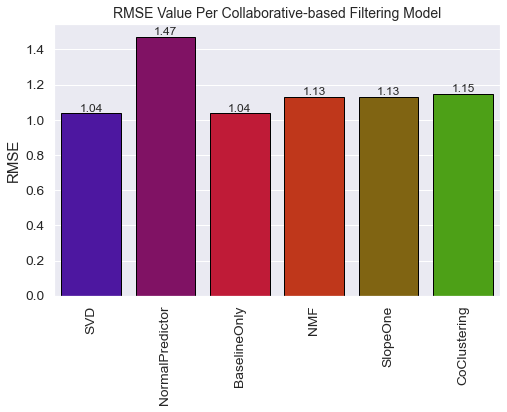

In [ ]:
# Compare RMSE values between models
fig,axis = plt.subplots(figsize=(8, 5))
rmse_x = ['SVD','NormalPredictor','BaselineOnly','NMF','SlopeOne','CoClustering']
rmse_y = [svd_rmse,np_rmse,blo_rmse,nmf_rmse,slo_rmse,cc_rmse]
ax = sns.barplot(x=rmse_x, y=rmse_y,palette='brg',edgecolor='black')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),2), fontsize=12, ha="center", va='bottom')
    
plt.show()

### Cross validation

Cross validation is a technique for determining the accuracy of a model's prediction on previously unseen data (validation sets). This is significant because it can help detect issues such as over/underfitting and selection bias. Cross validation was performed using the K-fold technique on our two best performing models, **SVD** and **BaselineOnly**.

**SVD**

In [ ]:
svd_test = SVD(n_epochs = 40, n_factors = 200, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, test_data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0319  1.0314  1.0137  1.0061  1.0189  1.0204  0.0100  
Fit time          3.86    4.14    4.04    4.63    4.45    4.23    0.28    
Test time         0.02    0.04    0.02    0.04    0.03    0.03    0.01    


**BaselineOnly**

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, test_data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0190  1.0160  1.0204  1.0149  1.0374  1.0215  0.0082  
Fit time          0.38    0.25    0.29    0.35    0.28    0.31    0.05    
Test time         0.02    0.14    0.03    0.02    0.02    0.05    0.05    


<a id="analysis"></a>
## 7. Model Analysis

In [6]:
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

# Load the 100k dataset
train_subset = train.iloc[:100000,:]
reader = Reader(rating_scale=(train_subset['rating'].min(), train_subset['rating'].max()))
data = Dataset.load_from_df(train_subset[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.20, random_state=42)

### Hyperparameter Tuning 

Hyperparameter tuning is the process by which a set of ideal hyperparameters are chosen for a model. A hyperparameter is a parameter for which the value is set manually and tuned to control the algorithm's learning process. We tested multiple parameters for our best performing model (i.e. **SVD**).

In [9]:
param_grid = {'n_epochs':[40], #[30,40,50],
              'n_factors':[400], #[100,200,300,400],
              'init_std_dev':[0.005], #[0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(data)
print('***Best score:***')
print(grid_SVD.best_score['rmse'])
print('***Best parameters:***')
print(grid_SVD.best_params['rmse'])

***Best score:***
0.9680189490247452
***Best parameters:***
{'n_epochs': 40, 'n_factors': 400, 'init_std_dev': 0.005, 'random_state': 42}


### Results

In [7]:
svd_test = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)
svd_mae = accuracy.mae(predictions)
svd_mse = accuracy.mse(predictions)


RMSE: 0.9749
MAE:  0.7514
MSE: 0.9505


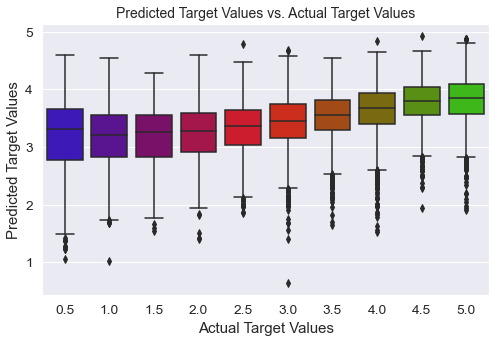

In [ ]:
# Predicted Target Values vs. Actual Target Values
new_df = pd.DataFrame(columns=['uid', 'iid', 'rating'])
i = 0
for (uid, iid, rating) in testset:
    new_df.loc[i] = [uid, iid, rating]
    i = i+1
true = new_df['rating']
pred = []
for i in predictions:
    pred.append(i.est)
fig,axis = plt.subplots(figsize=(8, 5))
sns.boxplot(x=true, y=pred, palette="brg")
plt.title("Predicted Target Values vs. Actual Target Values", fontsize=14)
plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.show()

<a id="conclusion"></a>
## 8. Conclusion

In this notebook, we created four distinct recommendation engines based on various ideas and algorithms:



1. **Simple Recommender:** This system constructed Top Movies Charts in general and for a specific genre using overall TMDB Vote Count and Vote Averages. The IMDB Weighted Rating System was used to calculate the ratings that were then sorted.

2. **Recommender Based on Content:** We created two content-based engines: one that used movie synopsis and taglines as input, and the other that used metadata such as cast, crew, genre, and keywords to make predictions. We also devised a simple filter to prioritize movies with more votes and higher ratings.

3. **Collaborative Filtering:** We built a collaborative filter based on single value decomposition using the powerful Surprise Library. The RMSE was less than one, and the engine returned estimated ratings for a given user and movie.

4. **Hybrid Engine:** We combined ideas from content and collaborative filtering to create an engine that suggested movies to a specific user based on the estimated ratings that it had internally calculated for that user.

<a id="submission"></a>
## 9. Submission

In [ ]:
# Train model on whole dataset
reader = Reader(rating_scale=(train['rating'].min(), train['rating'].max()))
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD(n_epochs = 40, n_factors = 400, init_std_dev = 0.005, random_state=42, verbose=True)
svd.fit(trainset)

# Create Kaggle submission file
predictions = []
for i, row in test.iterrows():
    x = (svd.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)
test['Id'] = test['userId'].map(str) +'_'+ test['movieId'].map(str)
results = pd.DataFrame({"Id":test['Id'],"rating": predictions})
results.to_csv("Team_ES2_submission.csv", index=False)

In [10]:
params = {"random_state": 7,
          "model_type": "logreg",
          "scaler": "standard scaler",
          "param_grid": str(param_grid),
          "stratify": True
          }
metrics = {"RMSE": svd_rmse,
           "MAE": svd_mae,
           "MSE": svd_mse
           }

In [11]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [12]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mowmanabdul/unsupervised-predict-team-es2/32bc968ab0b448b7b64708a40ac66852
COMET INFO:   Metrics:
COMET INFO:     MAE  : 0.7513843493367934
COMET INFO:     MSE  : 0.9504841790226943
COMET INFO:     RMSE : 0.9749277814395764
COMET INFO:   Parameters:
COMET INFO:     model_type   : logreg
COMET INFO:     param_grid   : {'n_epochs': [40], 'n_factors': [400], 'init_std_dev': [0.005], 'random_state': [42]}
COMET INFO:     random_state : 7
COMET INFO:     scaler       : standard scaler
COMET INFO:     stratify     : True
COMET INFO:   Uploads:
COMET INFO:     conda-info          : 1
COMET INFO:     conda-specification : 1
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO: 

<a id="reference"></a>
## 10. Reference

- Verma, Y., 2022. A Guide to Building Hybrid Recommendation Systems for Beginners. [online] Analytics India Magazine. Available at: <https://analyticsindiamag.com/a-guide-to-building-hybrid-recommendation-systems-for-beginners/> [Accessed 19 July 2022].
- Pillay, A., 2022. Python | Implementation of Movie Recommender System - GeeksforGeeks. [online] GeeksforGeeks. Available at: <https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/> [Accessed 17 July 2022].
- Jain, S., 2022. [online] Naukri.com. Available at: <https://www.naukri.com/learning/articles/movie-recommendation-system-using-machine-learning/> [Accessed 23 July 2022].
- https://www.researchgate.net/profile/Xiangjie-Kong-2/publication/330077673/figure/fig5/AS:710433577107459@1546391972632/A-hybrid-paper-recommendation-system.png
- Kniazieva, Y., 2022. Guide to Movie Recommendation Systems Using Machine Learning. [online] Labelyourdata.com. Available at: <https://labelyourdata.com/articles/movie-recommendation-with-machine-learning#:~:text=A%20movie%20recommendation%20system%2C%20or,their%20past%20choices%20and%20behavior. - https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/> [Accessed 17 July 2022].
- Trada, A., 2022. Movie recommendation System. [online] Medium. Available at: <https://medium.com/analytics-vidhya/movie-recommendation-system-aa204f0700eb> [Accessed 15 July 2022].